In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit, config
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from pathlib import Path

%matplotlib inline

In [2]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [3]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs


In [4]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=1000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)
        
        self.itercount = itertools.count()

        # Logger
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, y1, y2):
        y = np.stack([y1, y2])
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs

    # Define ODE/PDE residual
    def residual_net(self, params, u, y1, y2):
        s_y1 = grad(self.operator_net, argnums = 2)(params, u, y1, y2)
        s_y2 = grad(self.operator_net, argnums = 3)(params, u, y1, y2)
        res = s_y1**2 + s_y2**2
        return res

    # Define boundary loss
    def loss_bcs(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - pred.flatten())**2)
        return loss

    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:, 1])
        # Compute loss
        loss = np.mean((pred - 1.0)**2)
        return loss    
    
    # Define total loss
    def loss(self, params, bcs_batch, res_batch):
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss = loss_bcs + loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset, nIter = 10000):
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, bcs_batch, res_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_bcs' : loss_bcs_value, 
                                  'loss_res': loss_res_value})
       
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

In [5]:
# Geneate training data corresponding to zero boundary condition
def generate_bcs_training_data(key, m=100, P=100):
    # Sample a radius from an uniform distribution
    r = random.uniform(key)
    # Parameterzing the circle with polar coordinates
    fn_theta = lambda theta:  np.hstack([r * np.cos(theta), r * np.sin(theta)])
    # Discretize the parameter space 
    theta = np.linspace(0, 2 * np.pi, m)

    # Input sample 
    u =  vmap(fn_theta)(theta).reshape(1, -1)  # shape = (1, 2m)   (x1, y1, x2, y2, ...) 

    # Fixed sensors
    y1 = r * np.cos(theta)[:, None]
    y2 = r * np.sin(theta)[:, None]
    y =  np.hstack([y1, y2])  # shape = (m, 2)

    # Tile inputs
    u = np.tile(u, (P, 1))  # shape = (P, 2m) in this example P = m
    s = np.zeros((P, 1))

    return u, y, s 

# Geneate training data corresponding to PDE residual
def generate_res_training_data(key, m=100, P=1000):
    # Sample a radius from an uniform distribution
    r = random.uniform(key)
    # Parameterzing the circle with polar coordinates
    fn_theta = lambda theta:  np.hstack([r * np.cos(theta), r * np.sin(theta)])
    # Discretize the parameter space 
    theta = np.linspace(0, 2 * np.pi, m)

    # Input sample 
    u =  vmap(fn_theta)(theta).reshape(1, -1)  # shape = (1, 2m)   (x1, y1, x2, y2, ...) 
    # Collocation points in [-1, 1] x [-1, 1]
    y = - 1 + 2 * random.uniform(key, (P, 2))
    
    # Tile inputs
    u = np.tile(u, (P, 1))  # shape = (P, 2m) 
    s = np.zeros((P, 1))

    return u, y, s 

# Geneate test data 
def generate_test_data(key, m=100, P=100):
    r = random.uniform(key)

    fn_theta = lambda theta: np.hstack([r * np.cos(theta), r * np.sin(theta)])

    theta = np.linspace(0, 2 * np.pi, m)

    u = vmap(fn_theta)(theta).reshape(1, -1)  # shape = (1, 2m)   (x1, y1, x2, y2, ...) 

    y1 = np.linspace(-1, 1, P)
    y2 = np.linspace(-1, 1, P)

    y1, y2 = np.meshgrid(y1, y2)
    y = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))  # shape = (P, 2)

    # Tile inputs
    u = np.tile(u, (P**2, 1))  # shape = (P, 2m) in this example P = m

    # Exact solution
    def signed_dist(y1, y2):
      dist = np.sqrt(y1**2 +y2**2) - r
      return dist

    s = signed_dist(y[:,0:1], y[:,1:2])
    return r, u, y, s 

In [6]:
# Training data for boundary loss
N_train = 1000
m = 100 # number of input sensors
P_train = 100   # number of output sensors
key = random.PRNGKey(0) # use different key for generating test data 
keys = random.split(key, N_train)
gen_fn = jit(lambda key: generate_bcs_training_data(key, m, P_train))
u_train, y_train, s_train = vmap(gen_fn)(keys)
u_train = u_train.reshape(N_train * P_train,-1)
y_train = y_train.reshape(N_train * P_train,-1)
s_train = s_train.reshape(N_train * P_train,-1)


# Training data for residual loss
m = 100 # number of input sensors
P_r_train = 1000   # number of output sensors
key = random.PRNGKey(0) # use different key for generating test data 
keys = random.split(key, N_train)
gen_fn = jit(lambda key: generate_res_training_data(key, m, P_r_train))
u_r_train, y_r_train, s_r_train = vmap(gen_fn)(keys)
u_r_train = u_r_train.reshape(N_train * P_r_train,-1)
y_r_train = y_r_train.reshape(N_train * P_r_train,-1)
s_r_train = s_r_train.reshape(N_train * P_r_train,-1)

In [7]:
print(u_train.shape)
print(u_train)

(100000, 200)
[[ 1.3114643e-01  0.0000000e+00  1.3088240e-01 ... -8.3178030e-03
   1.3114643e-01  2.2930370e-08]
 [ 1.3114643e-01  0.0000000e+00  1.3088240e-01 ... -8.3178030e-03
   1.3114643e-01  2.2930370e-08]
 [ 1.3114643e-01  0.0000000e+00  1.3088240e-01 ... -8.3178030e-03
   1.3114643e-01  2.2930370e-08]
 ...
 [ 9.2989767e-01  0.0000000e+00  9.2802548e-01 ... -5.8977626e-02
   9.2989767e-01  1.6258848e-07]
 [ 9.2989767e-01  0.0000000e+00  9.2802548e-01 ... -5.8977626e-02
   9.2989767e-01  1.6258848e-07]
 [ 9.2989767e-01  0.0000000e+00  9.2802548e-01 ... -5.8977626e-02
   9.2989767e-01  1.6258848e-07]]


In [8]:
print(y_train.shape)
print(y_train)

(100000, 2)
[[ 1.3114643e-01  0.0000000e+00]
 [ 1.3088240e-01  8.3178217e-03]
 [ 1.3009134e-01  1.6602149e-02]
 ...
 [ 9.2241645e-01 -1.1771792e-01]
 [ 9.2802548e-01 -5.8977626e-02]
 [ 9.2989767e-01  1.6258848e-07]]


In [9]:
print(s_train.shape)
print(s_train)

(100000, 1)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [10]:
print(u_r_train.shape)
print(u_r_train)

(1000000, 200)
[[ 1.3114643e-01  0.0000000e+00  1.3088240e-01 ... -8.3178030e-03
   1.3114643e-01  2.2930370e-08]
 [ 1.3114643e-01  0.0000000e+00  1.3088240e-01 ... -8.3178030e-03
   1.3114643e-01  2.2930370e-08]
 [ 1.3114643e-01  0.0000000e+00  1.3088240e-01 ... -8.3178030e-03
   1.3114643e-01  2.2930370e-08]
 ...
 [ 9.2989767e-01  0.0000000e+00  9.2802548e-01 ... -5.8977626e-02
   9.2989767e-01  1.6258848e-07]
 [ 9.2989767e-01  0.0000000e+00  9.2802548e-01 ... -5.8977626e-02
   9.2989767e-01  1.6258848e-07]
 [ 9.2989767e-01  0.0000000e+00  9.2802548e-01 ... -5.8977626e-02
   9.2989767e-01  1.6258848e-07]]


In [11]:
print(y_r_train.shape)
print(y_r_train)

(1000000, 2)
[[ 0.26591086 -0.27372742]
 [-0.6164832   0.7236173 ]
 [-0.44026184  0.7122555 ]
 ...
 [-0.4798715  -0.45065665]
 [-0.8808322  -0.5264492 ]
 [-0.64972067 -0.95641065]]


In [12]:
print(s_r_train.shape)
print(s_r_train)

(1000000, 1)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [13]:
# Initialize model
branch_layers = [2 * m, 50, 50, 50, 50, 50]
trunk_layers =  [2, 50, 50, 50, 50, 50, 50]
model = PI_DeepONet(branch_layers, trunk_layers)

# Before Training

In [ ]:
params = model.get_params(model.opt_state)

In [14]:
# Compute error
N_test = 1000
error = []
P_test=100

key_test = random.PRNGKey(12345)  # use different key for generating test data 
keys_test = random.split(key_test, N_test)

for k in range(N_test):
  if k % 100 == 0:
    # print(k)
    pass
  r_test, u_test, y_test, s_test = generate_test_data(keys_test[k], m, P=100)
  u_test = np.float32(u_test.reshape(1 * P_test**2,-1))
  y_test = np.float32(y_test.reshape(1 * P_test**2,-1))
  s_test = np.float32(s_test.reshape(1 * P_test**2,-1))

  s_pred = -model.predict_s(params, u_test, y_test)[:,None]  # If L2 error is too high, flip the sign of the result.
  error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 

  error.append(error_s)

error_s = np.array(error)
print('mean of relative L2 error of s: {:.2e}'.format(error_s.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error_s.std()))

mean of relative L2 error of s: 1.11e+00
std of relative L2 error of s: 1.00e-01


error_s: 1.025e+00


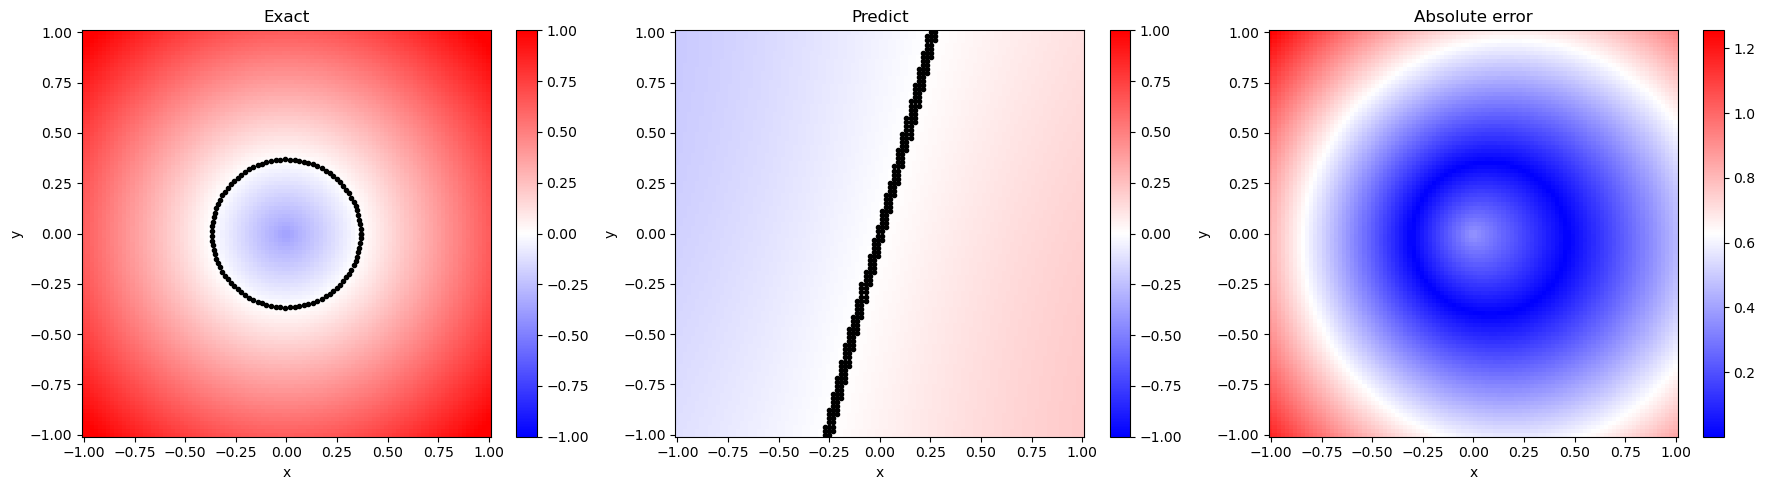

In [23]:
# Test data
N_test = 100
m = 100   # number of input sensors (needs to be the same as above!)
P_test = 10000   # number of output sensors
key = random.PRNGKey(1234567)  # use different key for generating test data 
keys = random.split(key, N_test)
gen_fn = jit(lambda key: generate_test_data(key, m, P=100))
r_test, u_test, y_test, s_test = vmap(gen_fn)(keys)

u_test = np.float32(u_test.reshape(N_test * P_test,-1))
y_test = np.float32(y_test.reshape(N_test * P_test,-1))
s_test = np.float32(s_test.reshape(N_test * P_test,-1))

s_pred = -model.predict_s(params, u_test, y_test)[:,None]  # If L2 error is too high, flip the sign of the result.

# Plot for one generated data
idx = 1
index = np.arange(idx * P_test,(idx + 1) * P_test)

theta = np.linspace(0, 2* np.pi, 100)

u1 = r_test[idx] * np.cos(theta)[:, None]
u2 = r_test[idx] * np.sin(theta)[:, None]

error_s = np.linalg.norm(s_test[index, :] - s_pred[index, :]) / np.linalg.norm(s_test[index, :]) 

print("error_s: {:.3e}".format(error_s))

y1 = np.linspace(-1,1, 100)
y2 = np.linspace(-1,1, 100)

y1, y2 = np.meshgrid(y1, y2)
y_star = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))

S_star = griddata(y_star, s_test[index, :].flatten(), (y1, y2), method='cubic')
S_pred = griddata(y_star, s_pred[index, :].flatten(), (y1, y2), method='cubic')
mask = np.abs(s_pred[index, :]) < 5e-3
Y1 = y1.flatten()[:, None][mask]
Y2 = y2.flatten()[:, None][mask]

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.pcolor(y1, y2, S_star, cmap='bwr')
plt.plot(u1, u2, '.', color='black')
plt.title('Exact')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.clim(-1, 1)
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(y1, y2, S_pred, cmap='bwr')
plt.plot(Y1, Y2, '.', color='black')
plt.colorbar()
plt.clim(-1, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predict')
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(y1, y2, np.abs(S_pred- S_star), cmap='bwr')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

# Training

In [14]:
# Create data set
# batch_size = 10000
# bcs_dataset = DataGenerator(u_train, y_train, s_train, batch_size)
# res_dataset = DataGenerator(u_r_train, y_r_train, s_r_train, batch_size)

In [15]:
# Train
# model.train(bcs_dataset, res_dataset, nIter=40000)

100%|██████████| 40000/40000 [03:11<00:00, 209.37it/s, Loss=0.00016076482, loss_bcs=3.510554e-06, loss_res=0.00015725427]  


In [24]:
path = Path('TrainedModels/circle')
path.mkdir(parents=True, exist_ok=True)

In [21]:
# Save the trained 
# params = model.get_params(model.opt_state)
# flat_params, _  = ravel_pytree(params)
# np.save(path/'ei_params.npy', flat_params)
# np.save(path/'ei_loss.npy', model.loss_log)
# np.save(path/'ei_loss_bcs.npy', model.loss_bcs_log)
# np.save(path/'ei_loss_res.npy', model.loss_res_log)

In [29]:
# Restore the trained model
flat_params = np.load(path/'ei_params.npy')
loss_bcs_log = np.load(path/'ei_loss_bcs.npy')
loss_res_log = np.load(path/'ei_loss_res.npy')
params = model.unravel_params(flat_params)

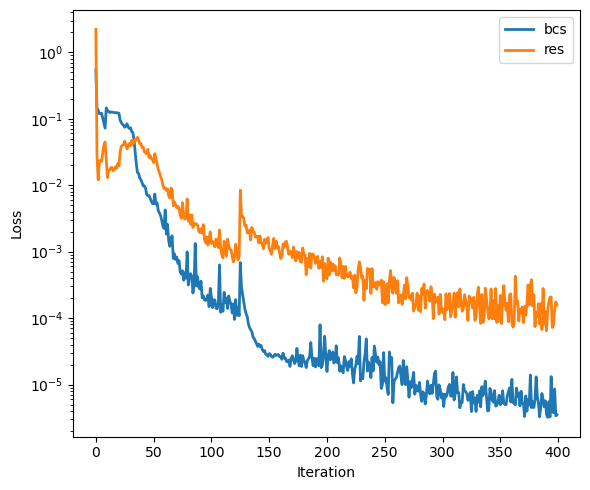

In [26]:
#Plot for loss function
plt.figure(figsize = (6,5))
plt.plot(loss_bcs_log, lw=2, label='bcs')
plt.plot(loss_res_log, lw=2, label='res')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# After Training

In [30]:
# Compute error
N_test = 1000
error = []
P_test=100

key_test = random.PRNGKey(12345)  # use different key for generating test data 
keys_test = random.split(key_test, N_test)

for k in range(N_test):
  if k % 100 == 0:
    # print(k)
    pass
  r_test, u_test, y_test, s_test = generate_test_data(keys_test[k], m, P=100)
  u_test = np.float32(u_test.reshape(1 * P_test**2,-1))
  y_test = np.float32(y_test.reshape(1 * P_test**2,-1))
  s_test = np.float32(s_test.reshape(1 * P_test**2,-1))

  s_pred = -model.predict_s(params, u_test, y_test)[:,None]  # If L2 error is too high, flip the sign of the result.
  error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 

  error.append(error_s)

error_s = np.array(error)
print('mean of relative L2 error of s: {:.2e}'.format(error_s.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error_s.std()))

mean of relative L2 error of s: 6.69e-03
std of relative L2 error of s: 1.96e-03


error_s: 5.379e-03


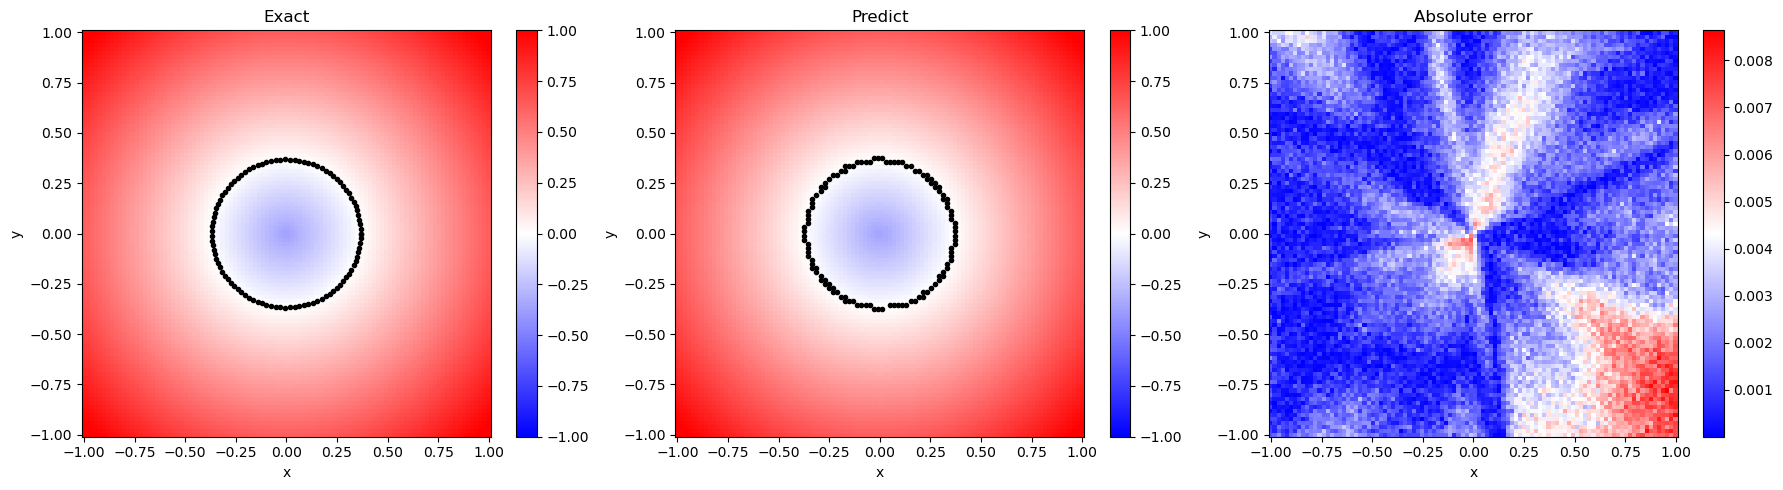

In [35]:
# Test data
N_test = 100
m = 100   # number of input sensors (needs to be the same as above!)
P_test = 10000   # number of output sensors
key = random.PRNGKey(1234567)  # use different key for generating test data 
keys = random.split(key, N_test)
gen_fn = jit(lambda key: generate_test_data(key, m, P=100))
r_test, u_test, y_test, s_test = vmap(gen_fn)(keys)

u_test = np.float32(u_test.reshape(N_test * P_test,-1))
y_test = np.float32(y_test.reshape(N_test * P_test,-1))
s_test = np.float32(s_test.reshape(N_test * P_test,-1))

s_pred = -model.predict_s(params, u_test, y_test)[:,None]  # If L2 error is too high, flip the sign of the result.

# Plot for one generated data
idx = 1
index = np.arange(idx * P_test,(idx + 1) * P_test)

theta = np.linspace(0, 2* np.pi, 100)

u1 = r_test[idx] * np.cos(theta)[:, None]
u2 = r_test[idx] * np.sin(theta)[:, None]

error_s = np.linalg.norm(s_test[index, :] - s_pred[index, :]) / np.linalg.norm(s_test[index, :]) 

print("error_s: {:.3e}".format(error_s))

y1 = np.linspace(-1,1, 100)
y2 = np.linspace(-1,1, 100)

y1, y2 = np.meshgrid(y1, y2)
y_star = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))

S_star = griddata(y_star, s_test[index, :].flatten(), (y1, y2), method='cubic')
S_pred = griddata(y_star, s_pred[index, :].flatten(), (y1, y2), method='cubic')
mask = np.abs(s_pred[index, :]) < 1e-2
Y1 = y1.flatten()[:, None][mask]
Y2 = y2.flatten()[:, None][mask]

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.pcolor(y1, y2, S_star, cmap='bwr')
plt.plot(u1, u2, '.', color='black')
plt.title('Exact')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.clim(-1, 1)
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(y1, y2, S_pred, cmap='bwr')
plt.plot(Y1, Y2, '.', color='black')
plt.colorbar()
plt.clim(-1, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predict')
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(y1, y2, np.abs(S_pred- S_star), cmap='bwr')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute error')
plt.tight_layout()
plt.show()